# Differentiable Procedural Generation

The idea behind differentiable procgen is to solve for procgen parameters rather than hand tune them. Many popular roguelikes have hand-tuned procgen parameters. It is not clear how they were derived, what effect changing them has, or how they interact with each other.

## Angband

https://github.com/angband/angband/blob/master/lib/gamedata/dungeon_profile.txt

```
params:11:50:200:2
tunnel:10:30:15:25:50
streamer:5:2:3:90:2:40
cutoff:100
```

## Crawl

https://github.com/crawl/crawl/blob/master/crawl-ref/source/dgn-layouts.cc

```c
// Make some rooms:
int doorlevel = random2(11);
int roomsize  = 4 + random2(5);
roomsize += random2(6); // force a sequence point between random calls
```

## NetHack

https://github.com/NetHack/NetHack/blob/NetHack-3.6.2/src/mklev.c

```c
if (!rn2(50))
```

## Pixel Dungeon

For example Pixel Dungeon's level generator https://github.com/watabou/pixel-dungeon/blob/master/src/com/watabou/pixeldungeon/levels/RegularLevel.java

```java
int nConnected = (int)(rooms.size() * Random.Float( 0.5f, 0.7f ));
```

How can these parameters be derived?

Consider generation as a function of parameters, and random input.

```python
def gen(parameters, random_input)
    # Use parameters and random_input to make dungeon
    return dungeon
```

Also consider a loss function as a function of parameters, random input, and a target value where the target value is a scalar.

```python
def loss(parameters, random_input, target):
    dungeon = gen(parameters, random_input)
    # score the dungeon and compare to target
    score = ???
    return (score - target) ** 2
```


If the loss function is differentiable (implying that the gen function is also differentiable) then the gradient of the score with respect to parameters can be calculated. Using the gradient, the parameters can be adjusted to minimize loss.

In [ ]:
!pip install --upgrade jax jaxlib matplotlib seaborn tensorflow joblib

In [1]:
import sys

In [2]:
sys.version

'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [3]:
sys.path

['/Users/aaron/src/notebooks',
 '/Users/aaron/anaconda3/envs/diff_procgen/lib/python37.zip',
 '/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7',
 '/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/lib-dynload',
 '',
 '/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages',
 '/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/IPython/extensions',
 '/Users/aaron/.ipython']

In [4]:
import os
from joblib import Parallel, delayed
import multiprocessing
import time
import itertools

import numpy as onp
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax import grad, jit, vmap, random
from jax.scipy.special import logsumexp, expit
from jax.experimental import optimizers
import jax.experimental.stax as stax
import jax.random as random

import tensorflow as tf
from tensorflow.contrib.image import connected_components

/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aaron/anaconda3/envs/diff_procgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aaron/anaconda3/envs/

In [5]:
num_cores = multiprocessing.cpu_count()

# Cave Generation

Optimize for 50% walls 50% open space

In [86]:
cols = 21
rows = 21
WALL = 1.
SPACE = 0.

key = random.PRNGKey(1)
# kernel that counts number of adjacent 1's
kernel = jax.numpy.ones((1, 1, 3, 3))
print(kernel.shape)

def print_map(a, threshold=0.5):
    print(np.where(a[0, 0] > threshold , ord(' '), ord('#')).astype(np.uint8)._value.view(f'S{a.shape[2]}'))

def caves_discrete(p):
    a = np.where(random.uniform(key, shape=(rows, cols)) < p, SPACE, WALL)[None, None, :, :]
    for i in range(4):
        conv = jax.lax.conv(a, kernel, (1, 1), "SAME")
        a = np.where(conv < 5.0, SPACE, WALL)
    return a

(1, 1, 3, 3)


In [7]:
print_map(caves_discrete(0.50))

[[b'############  #######']
 [b'###########       ###']
 [b'###########       ###']
 [b'############     ####']
 [b'############    #####']
 [b'## ####  ###    #####']
 [b'#   ###  ###     ####']
 [b'#   ###  ##      ####']
 [b'#   #######      ####']
 [b'##   #######    #####']
 [b'###   ###############']
 [b'#### ################']
 [b'#####################']
 [b'########    #########']
 [b'########    #########']
 [b'########    #########']
 [b'#####################']
 [b'#####################']
 [b'#####################']
 [b'#####################']
 [b'#####################']]


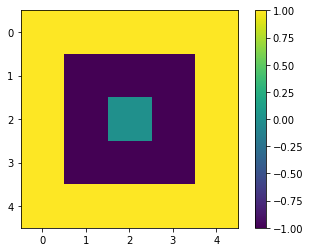

In [149]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def caves_continuous(params, x):
    # x (n, w, h)
    threshold = params[0]
    k = int((kernel.shape[2]-2)/2)
    a = jax.lax.lax.pad(x,
                        WALL,
                        [(0, 0, 0),
                         (0, 0, 0),
                         (k, k, 0),
                         (k, k, 0)])
    for i in range(4):
        conv = jax.lax.conv_general_dilated(a, kernel, (1, 1), "SAME",
                                              dimension_numbers=("NCWH", 'OIWH', "NCWH"))
        # a is the sigmoid(sum of neighbors - threshold)
        a = sigmoid(conv - threshold)
    return a

loss_kernel_cols = 5
loss_kernel_rows = 5
loss_kernel = jax.numpy.zeros((1, 1, loss_kernel_cols, loss_kernel_cols))
for i in range(int(loss_kernel_cols/2), 0, -1):
    index = jax.ops.index[0, 0,
                          int(loss_kernel_cols/2-i):int(loss_kernel_cols/2+i+1),
                          int(loss_kernel_cols/2-i):int(loss_kernel_cols/2+i+1)]
    loss_kernel = jax.ops.index_update(loss_kernel, index, 
                                  float(2. * i - 3))
loss_kernel = jax.ops.index_update(loss_kernel, jax.ops.index[0, 0,
                                                  int(loss_kernel_cols/2),
                                                  int(loss_kernel_cols/2)], 0.)
plt.imshow(loss_kernel[0, 0, :, :])
plt.colorbar()
def caves_loss_1(params, batch):
    x, y = batch
    out = caves_continuous(params, x)
    scores = np.mean(out, axis=(1, 2, 3))
    return np.mean((scores - y) ** 2.)

def caves_loss_2(params, batch):
    x, y = batch
    out = caves_continuous(params, x)
    # map 0.0, 1.0 to -1.0, 1.0, convolve with kernel
    conv = jax.lax.conv_general_dilated(out * 2.0- 1., loss_kernel * 2. - 1., (1, 1), "SAME",
                                        dimension_numbers=("NCWH", 'OIWH', "NCWH"))
    target = np.reshape(np.tile(y, (conv.shape[3], conv.shape[2], 1, 1)), (y.shape[0], 1, conv.shape[2], conv.shape[3]))
    #print("target.shape", target.shape)
    return np.sum((out - y) ** 2.) / x.shape[0]

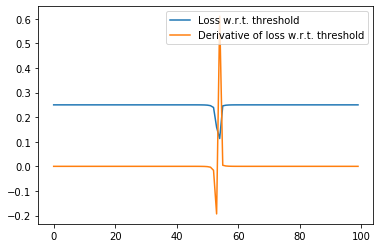

In [150]:
x = random.uniform(key, shape=(rows, cols))[None, None, :, :]
plt.plot([(caves_loss_1([p],(x, np.array([0.5]))))
          for p in np.linspace(-50, 50, 100)])
g = jit(grad(caves_loss_1))
plt.plot([g([p], (x, np.array([0.5])))
          for p in np.linspace(-50, 50, 100)])
plt.legend(['Loss w.r.t. threshold', 'Derivative of loss w.r.t. threshold'])

In [10]:
print_map(caves_continuous(np.array([4.3]), random.uniform(key, shape=(rows, cols))[None, None, :, :]))

[[b'#####################']
 [b'#############   #####']
 [b'##########       ####']
 [b'#########       #####']
 [b'#   ###         #####']
 [b'#    ##          ####']
 [b'#    ##          ####']
 [b'#    ##           ###']
 [b'#    #           ####']
 [b'##              #####']
 [b'##         ##########']
 [b'##         ##########']
 [b'###         #########']
 [b'#####         #######']
 [b'#####             ###']
 [b'#####              ##']
 [b'###    ####        ##']
 [b'##    ######       ##']
 [b'##   ########  ######']
 [b'### #################']
 [b'#####################']]


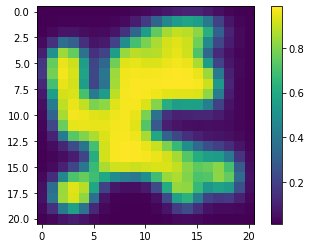

In [11]:
plt.imshow(caves_continuous([4.3], random.uniform(key, shape=(rows, cols))[None, None, :, :])[0,0,:,:])
plt.colorbar()

(1, 1, 21, 21)
(1, 1, 5, 5)


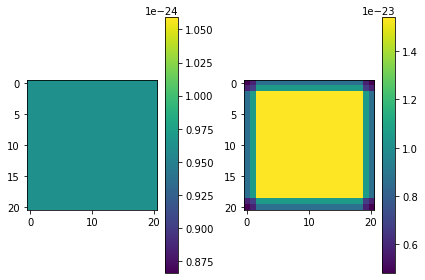

In [12]:
def f(out):
    print(out.shape)
    print(loss_kernel.shape)
    conv = jax.lax.conv(out, loss_kernel, (1, 1), "SAME")
    return conv

def plot_output_and_conv(params, x):
    out = caves_continuous(params, x)
    plt.subplot(121)
    plt.imshow(out[0,0,:,:])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(f(out)[0,0,:,:])
    plt.colorbar()
    plt.tight_layout()

plot_output_and_conv([55.3], random.uniform(key, shape=(rows, cols))[None, None, :, :])

Train Caves

Input shape: (1024, 1, 21, 21)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
Epoch 0 in 4.31 sec
Training set accuracy 0.29635709524154663
Test set accuracy 0.29635608196258545
Epoch 1 in 0.11 sec
Training set accuracy 0.29621174931526184
Test set accuracy 0.2962154150009155
Epoch 2 in 0.12 sec
Training set accuracy 0.29604437947273254
Test set accuracy 0.296066552400589
Epoch 3 in 0.12 sec
Training set accuracy 0.29587671160697937
Test set accuracy 0.29588010907173157
Epoch 4 in 0.12 sec
Training set accuracy 0.2956494092941284
Test set accuracy 0.2956731617450714
Epoch 5 in 0.11 sec
Training set accuracy 0.2954844534397125
Test set accuracy 0.2954905033111572
Epoch 6 in 0.11 sec
Training set accuracy 0.2952669858932495
Test set accuracy 0.2952885627746582
Epoch 7 in 0.11 sec
Training set accuracy 0.2950456738471985
Test set accuracy 0.29501333832740784
Epoch 8 in 0.11 sec
Training set accuracy 0.2947836220264435
Test set accuracy 0.294790774583

DeviceArray([4.3777256], dtype=float32)

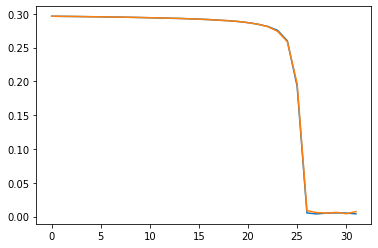

In [151]:
def cave_opt():
    init_rng = random.PRNGKey(0)
    step_size = 0.1
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 1, rows, cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([.45 for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(caves_loss_1)(params, batch), opt_state)

    init_params = np.array([2.])
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(caves_loss_1(params, epoch_batch))
        test_accs.append(caves_loss_1(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

cave_params = cave_opt()
cave_params

[4.3777256]
85.45736


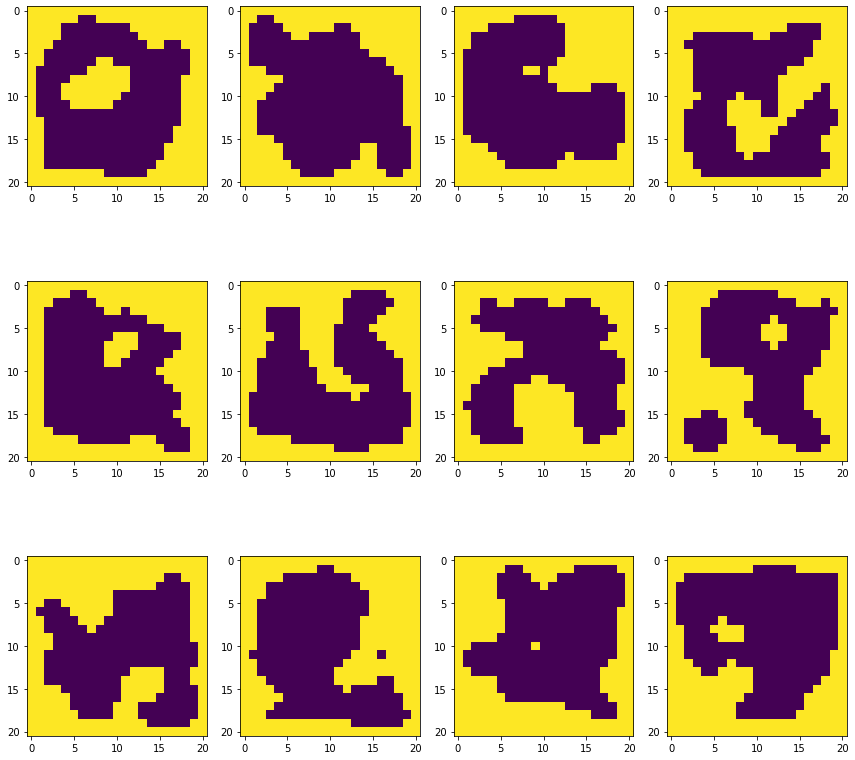

In [152]:
print(cave_params)
print(caves_loss(cave_params, (onp.random.rand(1, 1, rows, cols), np.array([0.45]))))

plt.subplots(figsize=(12, 12))

for i in range(1, 4):
    for j in range(1, 5):
        for _ in range(100):
            cs = np.where(caves_continuous(cave_params, onp.random.rand(1, 1, rows, cols)) > 0.5, 0., 1.)
            if np.sum(cs) < 250 :
                break
        plt.subplot(3, 4, (i - 1) * 4 + j)
        plt.imshow(onp.random.binomial(1, cs)[0, 0], vmin=0., vmax=1.)
plt.tight_layout()

# Graph Dungeon Generation

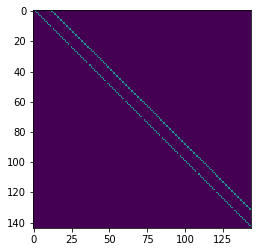

In [8]:
dungeon_cols = 12
dungeon_rows = 12

def make_adj_matrix(rows, cols):
    n = rows * cols
    M = np.zeros((1, 1, n, n))
    for r in range(rows):
        for c in range(cols):
            i = r * cols + c
            # Two inner diagonals
            if c > 0:
                #M[i - 1, i] = M[i, i - 1] = 1
                M = jax.ops.index_update(M, jax.ops.index[0, 0, i - 1, i], 1.)
                M = jax.ops.index_update(M, jax.ops.index[0, 0, i, i - 1], 1.)
            # Two outer diagonals
            if r > 0:
                #M[i - cols, i] = M[i, i - cols] = 1
                M = jax.ops.index_update(M, jax.ops.index[0, 0, i - cols, i], 1.)
                M = jax.ops.index_update(M, jax.ops.index[0, 0, i, i - cols], 1.)
    return np.triu(M)

mask = make_adj_matrix(dungeon_rows, dungeon_cols)
plt.imshow(np.multiply(mask,
                       np.full(mask.shape, .5))[0, 0, :, :], vmin=0., vmax=1.)

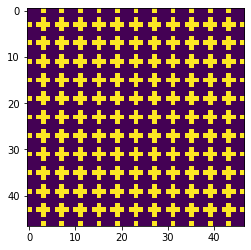

In [21]:
def draw_dungeon(M, cols, rows):
    dungeon = onp.ones((rows*4-1, cols*4-1))
    for src in range(M.shape[0]):
        for dest in range(M.shape[1]):
            corridor = M[src, dest]
            if src==dest:
                dungeon[4 * (src % cols) : 4 * (src % cols) + 3,
                        4 * (src // cols) : 4 * (src // cols) + 3] = 0.
            elif corridor > .5:
                src_col = (src % cols)
                src_row = src // cols
                dest_col = (dest % cols)
                dest_row = dest // cols
                dungeon[4 * (src_row + dest_row) // 2 + 1,
                        4 * (src_col + dest_col) // 2 + 1] = 0.
    plt.imshow(dungeon, vmin=0., vmax=1.)
draw_dungeon(mask[0, 0, :, :], dungeon_cols, dungeon_rows)

184


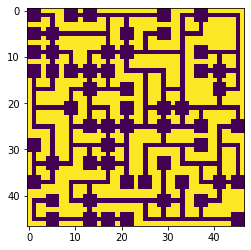

In [24]:
def make_dense_matrix(rows, cols):
    return np.zeros((1, 2, rows -1, cols - 1))

def draw_dense_dungeon(M):
    #M (batch, (0=horz/1=vert), row, col)
    rows = M.shape[2]
    cols = M.shape[3]
    #dungeon (row, col)
    dungeon = onp.ones((rows*4-1, cols*4-1))
    for row in range(rows):
        for col in range(cols):
            # TODO: logic. room
            # conn = 1. when there is a corridor
            conn = np.array([
                # above |
                row > 0 and M[0, 1, row - 1, col] == 1.,
                # below |
                row < rows - 1 and M[0, 1, row, col] == 1.,
                # left -
                col > 0 and M[0, 0, row, col - 1] == 1.,
                # right -
                col < cols - 1 and M[0, 0, row, col] == 1.]).astype(np.float32)
            if np.sum(conn) == 1. \
                or np.sum(conn) == 4. \
                or np.sum(conn) > 1. \
                    and onp.random.binomial(1, 0.85) == 0.:
                dungeon[4 * row : 4 * row + 3,
                        4 * col : 4 * col + 3] = 0.
            # horizontal corridors - (left and right)
            if col < cols - 1:
                corridor = M[0, 0, row, col]
                if corridor > 0.:
                    #dungeon[4 * row + 1, 4 * col + 3] = corridor
                    # d(row, col)
                    dungeon[4 * row + 1, (4 * col + 1):(4 * col + 6)] = 0.
            # vertical corridors | (above and below)
            if row < rows - 1:
                corridor = M[0, 1, row, col]
                if corridor > 0.:
                    #dungeon[4 * row + 3, 4 * col + 1] = corridor
                    dungeon[(4 * row + 1):(4 * row + 6), 4 * col + 1] = 0.
    return dungeon 

def plot_dense_dungeon(M):
    plt.imshow(draw_dense_dungeon(M), vmin=0., vmax=1.)
    
kernel = jax.numpy.ones((2, 2, 3, 3))/(3.*3.)
def dungeon(params, x):
    for i in range(2):
        kernel_a = params[i:i+1, 0:1, :, :]
        kernel_b = params[i:i+1, 1:2, :, :]
        a = x[:, 0:1, :, :]
        b = x[:, 1:2, :, :]
        #print("x", x.shape)
        #print("a", a.shape)
        #print("kernel_a", kernel_a.shape)
        #print("b", b.shape)
        #print("kernel_b", kernel_b.shape)
        conv_a = sigmoid(jax.lax.conv(a, kernel_a, (1, 1), "SAME"))
        conv_b = sigmoid(jax.lax.conv(b, kernel_b, (1, 1), "SAME"))
        x = np.stack([conv_a,
                      conv_b],
                     axis=2)[0]
    return x

d = onp.random.binomial(1, dungeon(kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
print(np.sum(d))
plot_dense_dungeon(d)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


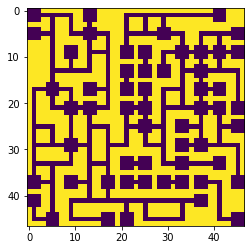

In [717]:
#draw_dense_dungeon(make_dense_matrix(dungeon_cols, dungeon_rows))

d = onp.random.binomial(1, dungeon(kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)*0.5+0.5))
print(draw_dense_dungeon(d))
plot_dense_dungeon(d)

In [718]:
# horizontal connections + vertical connections
num_edges_max = 2 * (dungeon_rows - 1) * (dungeon_cols - 1)
print(num_edges_max)

242


If the probability of edges is distributes according to bernoilli(p), what should p be in order to maximize large loops?

Graph density
<img src="https://www.python-course.eu/images/graph_density_formula.png" />

# TODO: Use ADAM optmizier

Input shape: (1024, 2, 12, 12)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 0 in 1.36 sec
Training set accuracy 6.378844738006592
Test set accuracy 6.378844738006592
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 1 in 0.12 sec
Training set accuracy 6.377216339111328
Test set accuracy 6.377216339111328
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 2 in 0.13 sec
Training set accuracy 6.375579357147217
Test set accuracy 6.375579357147217
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 3 in 0.11 sec
Training set accuracy 6.373936653137207
Test set accuracy 6.373936653137207
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
(2, 2, 5, 5) (32, 2, 12, 12) (32,)
Epoch 4 in 0.12 sec
Training set accuracy 6.372300148010254
Test set accuracy 6.372299671173096
(2, 2, 5, 5) (32, 

DeviceArray([[[[0.02002749, 0.02179979, 0.02317274, 0.02180232,
                0.02002242],
               [0.02179768, 0.02372788, 0.02521933, 0.02372704,
                0.02179298],
               [0.02314292, 0.02519096, 0.0267714 , 0.02518393,
                0.02313069],
               [0.0217872 , 0.02371475, 0.02519803, 0.02369753,
                0.02176142],
               [0.02000072, 0.02177146, 0.02313346, 0.02175196,
                0.01997033]],

              [[0.01996441, 0.02174337, 0.0230884 , 0.02173569,
                0.01996487],
               [0.02174311, 0.02367809, 0.02514473, 0.0236715 ,
                0.02174242],
               [0.02310359, 0.02515834, 0.02671805, 0.02515713,
                0.0231095 ],
               [0.02174249, 0.02367857, 0.02515056, 0.02368327,
                0.02175446],
               [0.01995966, 0.02173895, 0.02309096, 0.02174375,
                0.01997393]]],


             [[[0.08190097, 0.09026252, 0.09884953, 0.09026241,


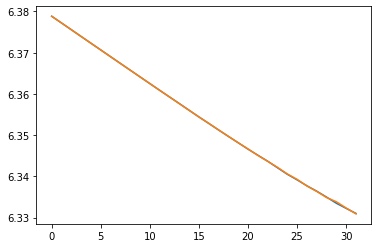

In [25]:
def dungeon_loss(params, batch):
    x, y = batch
    print(params.shape, x.shape, y.shape)
    out = dungeon(params, x)
    # map 0.0, 1.0 to -1.0, 1.0, convolve with kernel
    e = np.sum(out)
    v = np.prod(np.array(out.shape))
    d = 2. * e / (v * (v - 1.))
    return np.sum((d - y) ** 2.)

def dungeon_opt_1():
    init_rng = random.PRNGKey(0)
    step_size = 0.01
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 2, dungeon_rows, dungeon_cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([.45 for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(dungeon_loss)(params, batch), opt_state)

    init_params = np.zeros((2, 2, 5, 5))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(dungeon_loss(params, epoch_batch))
        test_accs.append(dungeon_loss(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

dungeon_params_1 = dungeon_opt_1()
dungeon_params_1

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


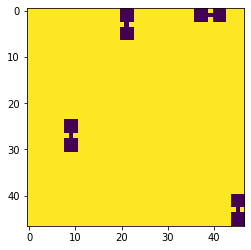

In [74]:
d = onp.random.binomial(1, dungeon(dungeon_params_1, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
print(draw_dense_dungeon(d))
plot_dense_dungeon(d)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 4 4 4]
 [0 0 0 ... 4 4 4]
 [0 0 0 ... 4 4 4]]
5


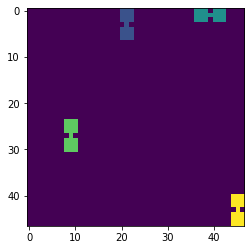

In [75]:
t = connected_components(draw_dense_dungeon(d) * -1. + 1.)
sess = tf.Session();
with sess.as_default():
    print(t.eval())
    print(len(onp.unique(t.eval())))
    plt.imshow(t.eval())

In [35]:
from tqdm import tqdm  
from os import path

num_epochs = 60
batch_size = 128

def gen(i):
    return onp.random.binomial(1, dungeon(kernel, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
def gen_target(ti):
    sess = tf.Session()
    return len(onp.unique(connected_components(draw_dense_dungeon(ti) * -1. + 1.).eval(session=sess)))

if path.exists('cc_train.npy') and path.exists('cc_y.npy'):
    train_images = np.load('cc_train.npy')
    train_cc = np.load('cc_y.np')
else:
    print('generating inputs')
    train_images = Parallel(n_jobs=num_cores)(delayed(gen)(i) for i in tqdm(range(num_epochs * batch_size)))
    print('generated responses')
    train_cc = Parallel(n_jobs=num_cores)(delayed(gen_target)(ti) for ti in tqdm(train_images))

    train_images = np.squeeze(np.stack(train_images), 1).astype(np.float32)
    train_cc = np.squeeze(np.stack(train_cc), 1).astype(np.float32)
    np.save('cc_train.npy', train_images)
    np.save('cc_y.npy', train_cc)

print(train_images.shape, train_images.dtype)
print(train_cc.shape, train_cc.dtype)

  0%|          | 0/7680 [00:00<?, ?it/s]

generating inputs


  0%|          | 0/7680 [00:00<?, ?it/s]

generated responses


100%|██████████| 7680/7680 [1:43:31<00:00,  3.36s/it]  


(7680, 2, 12, 12) float32
(7680,) float32


(array([2660., 1948., 1471.,  882.,  393.,  206.,   86.,   26.,    5.,
           3.]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ],
       dtype=float32),
 <a list of 10 Patch objects>)

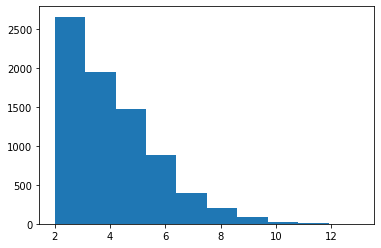

In [38]:
plt.hist(train_cc)


Starting training...
Epoch init 
Training set accuracy 42.33572769165039
Test set accuracy 55.41054916381836
Epoch 0 in 101.25 sec
Training set accuracy 2.752761125564575
Test set accuracy 2.7815303802490234
Epoch 1 in 14.61 sec
Training set accuracy 2.655717611312866
Test set accuracy 2.8646185398101807
Epoch 2 in 8.81 sec
Training set accuracy 2.638641119003296
Test set accuracy 2.758981227874756
Epoch 3 in 10.16 sec
Training set accuracy 2.6261518001556396
Test set accuracy 2.915783643722534
Epoch 4 in 8.49 sec
Training set accuracy 2.6168103218078613
Test set accuracy 4.9119439125061035
Epoch 5 in 7.17 sec
Training set accuracy 2.6097207069396973
Test set accuracy 3.2304508686065674
Epoch 6 in 7.25 sec
Training set accuracy 2.6035754680633545
Test set accuracy 5.24857759475708
Epoch 7 in 8.59 sec
Training set accuracy 2.59816575050354
Test set accuracy 1.369015097618103
Epoch 8 in 13.13 sec
Training set accuracy 2.593513250350952
Test set accuracy 1.7831485271453857
Epoch 9 in 18.

[(DeviceArray([[[[-0.29008982],
                 [-1.292377  ]]]], dtype=float32),
  DeviceArray(0.00070095, dtype=float32)),
 (),
 ([(), (), (), (), ([(), (), ()], [(), (), ()]), ()],
  [(), (), (), (), ([(), (), ()], [(), (), ()]), ()]),
 (),
 (DeviceArray([[[[-0.5217396 , -0.28682232]],
  
                [[ 0.59042603, -0.11222271]],
  
                [[-0.00457108,  0.13414569]]],
  
  
               [[[-0.20868473, -0.18844296]],
  
                [[-0.26847968, -0.2108032 ]],
  
                [[-0.07484221,  0.39560109]]],
  
  
               [[[-0.21489242,  0.29113781]],
  
                [[-0.52264774, -0.02135346]],
  
                [[ 0.60744876,  0.48737505]]]], dtype=float32),
  DeviceArray([ 0.00151416, -0.02487639], dtype=float32)),
 (),
 (DeviceArray([[[[ 0.18965444],
                 [-2.87545681]]]], dtype=float32),
  DeviceArray(0.03477378, dtype=float32)),
 (DeviceArray([[-0.17862847, -0.08507352,  0.70559317, -0.13392101,
                 0.41176376, -0.1

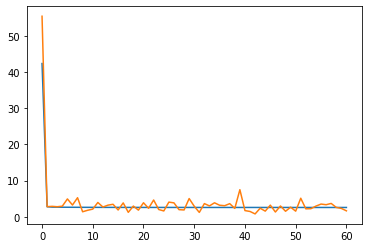

In [39]:
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, Dropout, FanInConcat,
                                   FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, SumPool, LogSoftmax)

def sigmoid(x): return expit(x)
def elu(x): return np.where(x > 0, x, np.expm1(x))
def leaky_relu(x): return np.where(x >= 0, x, 0.01 * x)
Sigmoid = stax.elementwise(sigmoid)
Elu = stax.elementwise(elu)
LeakyRelu = stax.elementwise(leaky_relu)
MinPool = stax._pooling_layer(jax.lax.max, -np.inf)

init_random_params, predict = stax.serial(
    GeneralConv(('NCHW', 'HWIO', 'NHWC'), 1, (1, 1), (1, 1), "SAME"),
    FanOut(2),
    stax.parallel(
        stax.serial(
            MinPool((3, 3), strides=(3, 3)),
            Dropout(0.5),
            Sigmoid,
            FanOut(2),
            stax.parallel(
                stax.serial(
                    MinPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid),
                stax.serial(
                    MaxPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid)),
            FanInConcat(1)),
        stax.serial(
            MaxPool((3, 3), strides=(3, 3)),
            Dropout(0.5),
            Sigmoid,
            FanOut(2),
            stax.parallel(
                stax.serial(
                    MinPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid),
                stax.serial(
                    MaxPool((3, 3), strides=(3, 3)),
                    Dropout(0.5),
                    Sigmoid)),
            FanInConcat(1))),
    FanInConcat(1),
    GeneralConv(('NHWC', 'HWIO', 'NHWC'), 2, (3, 3), (1, 1), "SAME"),
    Sigmoid,
    GeneralConv(('NHWC', 'HWIO', 'NHWC'), 1, (1, 1), (1, 1), "SAME"),
    Dense(16), Sigmoid,
    Dropout(0.5),
    Dense(16), Sigmoid,
    Dropout(0.5),
    Dense(8), Sigmoid,
    Dense(1))

def loss(params, batch, **kwargs):
    inputs, targets = batch
    preds = predict(params, inputs, **kwargs)
    #print(inputs.shape, targets.shape, preds.shape)
    return np.mean((preds - targets) ** 2)

def accuracy(params, batch, **kwargs):
    inputs, targets = batch
    preds = predict(params, inputs, **kwargs)
    #print(inputs.shape, targets.shape, preds.shape)
    return np.mean((preds - targets) ** 2)

def test_accuracy(params):
    test_images = Parallel(n_jobs=num_cores)(delayed(gen)(i) for i in range(16))
    test_cc = Parallel(n_jobs=num_cores)(delayed(gen_target)(ti) for ti in test_images)

    test_images = np.squeeze(np.stack(test_images), 1).astype(np.float32)
    test_cc = np.squeeze(np.stack(test_cc), 1).astype(np.float32)
    test_acc = accuracy(params, (test_images, test_cc), rng=random.PRNGKey(0))
    return test_acc

def ccnet():
    init_rng = random.PRNGKey(0)
    step_size = 0.01
    momentum_mass = 0.9
    #train_images, _, test_images, _ = datasets.mnist(permute_train=True)
    num_train = train_images.shape[0]
    num_complete_batches, leftover = divmod(train_images.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    nun_epochs = 60

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_images[batch_idx], train_cc[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch, rng=rng), opt_state)

    _, init_params = init_random_params(init_rng, (-1, 2, dungeon_rows, dungeon_cols))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    losses.append(train_acc)
    test_acc = test_accuracy(params)
    test_accs.append(test_acc)
    print("Epoch init ")
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        for _ in range(num_batches):
            opt_state = update(rng, next(itercount), opt_state, next(batches))
        params = get_params(opt_state)
        train_acc = accuracy(params, (train_images, train_cc), rng=rng)
        losses.append(train_acc)
        test_acc = test_accuracy(params)
        test_accs.append(test_acc)
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_acc))
        print("Test set accuracy {}".format(test_acc))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

cc_params = ccnet()
cc_params

In [40]:
import graphviz as gv

src = gv.Source(jax.api._make_graphviz(predict)(params, train_images, rng=random.PRNGKey(0)))
#print(src.source)
src.view()

NameError: name 'params' is not defined

In [41]:
print("Test set accuracy {}".format(test_accuracy(cc_params)))

Test set accuracy 1.6671602725982666


Input shape: (1024, 2, 12, 12)
Output shape (1024,)
Num Epochs: 32
Num Batches: 32

Starting training...
Epoch init 
Epoch 0 in 3.70 sec
Training set accuracy 18.888938903808594
Test set accuracy 18.888938903808594
Epoch 1 in 0.12 sec
Training set accuracy 18.8887939453125
Test set accuracy 18.8887939453125
Epoch 2 in 0.12 sec
Training set accuracy 18.888639450073242
Test set accuracy 18.888639450073242
Epoch 3 in 0.13 sec
Training set accuracy 18.88848876953125
Test set accuracy 18.88848876953125
Epoch 4 in 0.13 sec
Training set accuracy 18.888334274291992
Test set accuracy 18.888334274291992
Epoch 5 in 0.11 sec
Training set accuracy 18.88818359375
Test set accuracy 18.88818359375
Epoch 6 in 0.10 sec
Training set accuracy 18.888031005859375
Test set accuracy 18.888031005859375
Epoch 7 in 0.10 sec
Training set accuracy 18.88787841796875
Test set accuracy 18.88787841796875
Epoch 8 in 0.10 sec
Training set accuracy 18.887727737426758
Test set accuracy 18.887727737426758
Epoch 9 in 0.14 s

DeviceArray([[[[ 0.00222962,  0.00242354,  0.00256803,  0.00242344,
                 0.00223156],
               [ 0.00242009,  0.00263096,  0.00278868,  0.00263241,
                 0.00242475],
               [ 0.00256429,  0.00278772,  0.00295527,  0.00278999,
                 0.00257026],
               [ 0.00241829,  0.00262932,  0.00278786,  0.00263257,
                 0.00242566],
               [ 0.00222514,  0.00241954,  0.00256571,  0.00242297,
                 0.00223263]],

              [[ 0.00221495,  0.00240648,  0.00255323,  0.0024098 ,
                 0.00221801],
               [ 0.00240578,  0.00261379,  0.00277367,  0.00261772,
                 0.00240976],
               [ 0.00255058,  0.00277135,  0.00294079,  0.00277568,
                 0.00255518],
               [ 0.00240682,  0.00261545,  0.00277527,  0.00261959,
                 0.00241147],
               [ 0.0022143 ,  0.00240616,  0.00255312,  0.00240973,
                 0.00221805]]],


             [

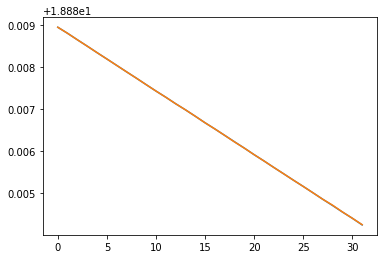

In [79]:
@jit
def dungeon_loss_2(params, batch):
    '''Simultaneously lower density and number of connected components'''
    x, y = batch
    out = dungeon(params, x)
    # map 0.0, 1.0 to -1.0, 1.0, convolve with kernel
    e = np.sum(out)
    v = np.prod(np.array(out.shape))
    # d=density
    d = 2. * e / (v * (v - 1.))
    cc = predict(cc_params, out, rng=random.PRNGKey(0))
    return np.mean(((d + cc) - y) ** 2.)

def dungeon_opt_2():
    init_rng = random.PRNGKey(0)
    step_size = 0.01
    momentum_mass = 0.9
    num_epochs = 32
    batch_size = 32
    train_X = np.squeeze(np.array([onp.random.rand(1, 2, dungeon_rows, dungeon_cols) for _ in range(num_epochs * batch_size)]), 1)
    train_y = np.array([0. for _ in range(train_X.shape[0])])
    num_train = train_X.shape[0]
    num_complete_batches, leftover = divmod(train_X.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    print("Input shape:", train_X.shape)
    print("Output shape", train_y.shape)
    print("Num Epochs:", num_epochs)
    print("Num Batches:", num_batches)

    def data_stream():
        rng = onp.random.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_X[batch_idx], train_y[batch_idx]
    batches = data_stream()
  


    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    @jit
    def update(rng, i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(dungeon_loss_2)(params, batch), opt_state)

    init_params = np.zeros((2, 2, 5, 5))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    
    print("\nStarting training...")
    losses = []
    test_accs = []
    params = get_params(opt_state)
    #train_acc = accuracy(params, (train_images, train_cc), rng=init_rng)
    #losses.append(train_acc)
    #test_acc = test_accuracy(params)
    #test_accs.append(test_acc)
    print("Epoch init ")
    #print("Training set accuracy {}".format(train_acc))
    #print("Test set accuracy {}".format(test_acc))

    for epoch in range(num_epochs):
        rng = random.PRNGKey(epoch)
        start_time = time.time()
        epoch_batch = None
        for _ in range(num_batches):
            batch = next(batches)
            epoch_batch = batch
            opt_state = update(rng, next(itercount), opt_state, batch)
        params = get_params(opt_state)
        losses.append(dungeon_loss_2(params, epoch_batch))
        test_accs.append(dungeon_loss_2(params, next(batches)))
        epoch_time = time.time() - start_time
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(losses[-1]))
        print("Test set accuracy {}".format(test_accs[-1]))
    plt.plot(losses)
    plt.plot(test_accs)
    return params

dungeon_params_2 = dungeon_opt_2()
dungeon_params_2

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [14 14 14 ...  9  9  9]
 [14 14 14 ...  9  9  9]
 [14 14 14 ...  9  9  9]]
[[   0    1    7    9    3    8    2   14   13   12   11   10    6    5
     4]
 [1326  222  197  116   86   83   27   19   19   19   19   19   19   19
    19]]


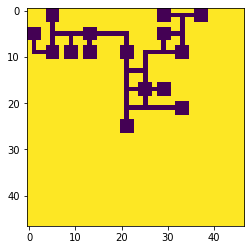

In [80]:
d = onp.random.binomial(1, dungeon(dungeon_params_2, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
t = connected_components(draw_dense_dungeon(d) * -1. + 1.)
sess = tf.Session();
with sess.as_default():
    #print(t.eval())
    te = t.eval()
    print(te)
    a = onp.array(onp.unique(te, return_counts=True))
    sorted_cc = a[:, a[1,:].argsort()[::-1]]
    print(sorted_cc)
    plt.imshow(onp.where(te == sorted_cc[0, 1], 0., 1.), vmin=0., vmax=1.)

[[   0    8   19   18    2   14   17    1    4    3    5    6    7   21
     9   20   11   12   13   15   16   10]
 [1341  180  148  115   58   54   23   23   23   19   19   19   19   19
    19   19   19   19   19   19   19   16]]
[[   0    3    5   12   16    9    6   21    8   18   15    1   19   13
    22   10    4    2   23    7   14   17   20   11]
 [1367  153   83   58   52   47   44   42   38   27   27   23   23   23
    23   23   23   19   19   19   19   19   19   19]]
[[   0    1   12    3    6   13    5    8   11   10   14    9    7    4
     2]
 [1396  190  117  115   78   64   57   51   23   23   19   19   19   19
    19]]
[[   0   11    1   14    9   12    2    7    6    3   16   15    5    4
    10   13    8]
 [1329  182  177  123   80   52   38   37   27   23   23   23   19   19
    19   19   19]]
[[   0    2   12    1    5   17    4    8   15   14    7   13   11   10
     6    9   16    3]
 [1263  213  175  105   80   43   39   39   38   34   27   27   23   23
    23   

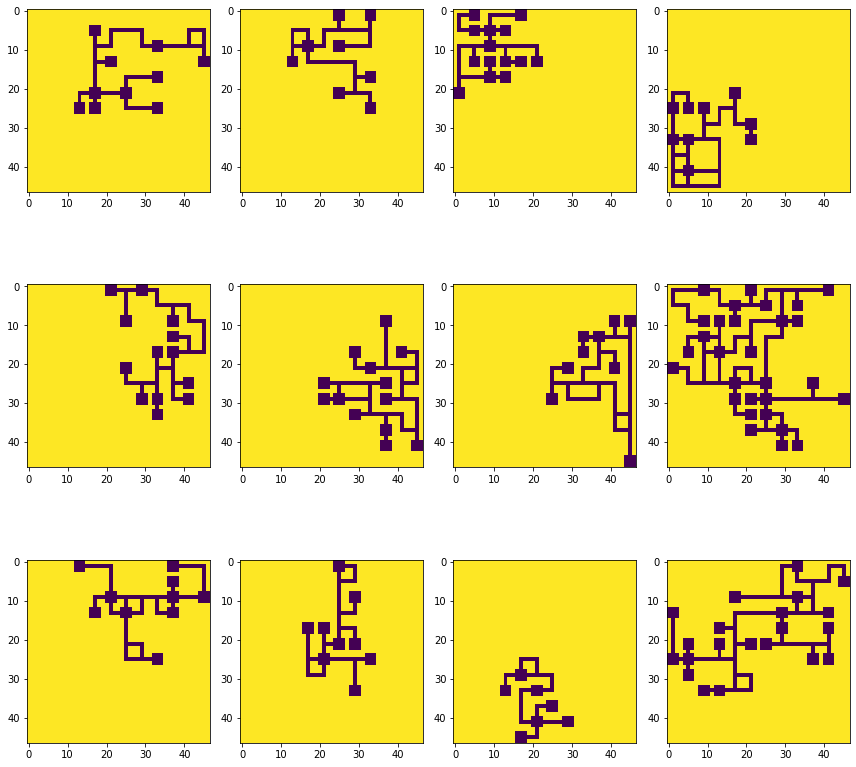

In [81]:
plt.subplots(figsize=(12, 12))
sess = tf.Session();
with sess.as_default():
    for i in range(1, 4):
        for j in range(1, 5):
            d = onp.random.binomial(1, dungeon(dungeon_params_2, onp.random.rand(1, 2, dungeon_rows, dungeon_cols)))
            t = connected_components(draw_dense_dungeon(d) * -1. + 1.).eval()
            a = onp.array(onp.unique(t, return_counts=True))
            sorted_cc = a[:, a[1,:].argsort()[::-1]]
            #print(4, 5, (i - 1) * 4 + j)
            plt.subplot(3, 4, (i - 1) * 4 + j)
            plt.imshow(onp.where(t == sorted_cc[0, 1], 0., 1.), vmin=0., vmax=1.)
plt.tight_layout()